# Notebook preparation

## Install dependencies

In [1]:
%%capture
!pip install numpy pandas tensorflow tensorflow_datasets matplotlib seaborn

## Import code dependencies

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
print('Packages imported successfully');

Packages imported successfully


In [3]:
def print_versions():
  print('tensorflow: ', tf.__version__)
  print('tensorflow_datasets: ', tfds.__version__)

print_versions()

tensorflow:  2.17.0
tensorflow_datasets:  4.9.6


# Load and examine dataset 
Download [The Malaria dataset](https://www.tensorflow.org/datasets/catalog/malaria)

In [4]:
ds, info = tfds.load('malaria', split='train', shuffle_files=False, with_info=True)

## Verify that the dataset conforms to documentation
The metadata _features_ and _splits_ are according to documenation expected to be similar to
```
info.features= FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
})
info.splits= {'train': <SplitInfo num_examples=27558, num_shards=4>}
```
This fits our expectation that the data contains a training set consisting of nand valiumerically (0, 1) labelled images.
The dataset has only a single split, so we have to devise a strategy for spliiting into train, test and validation.

In [5]:
print('info.features=', info.features)
print('info.splits=', info.splits)

info.features= FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
})
info.splits= {'train': <SplitInfo num_examples=27558, num_shards=4>}


## Understanding the dataset

### Preview a sample from the dataset

2024-10-24 16:02:22.601198: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


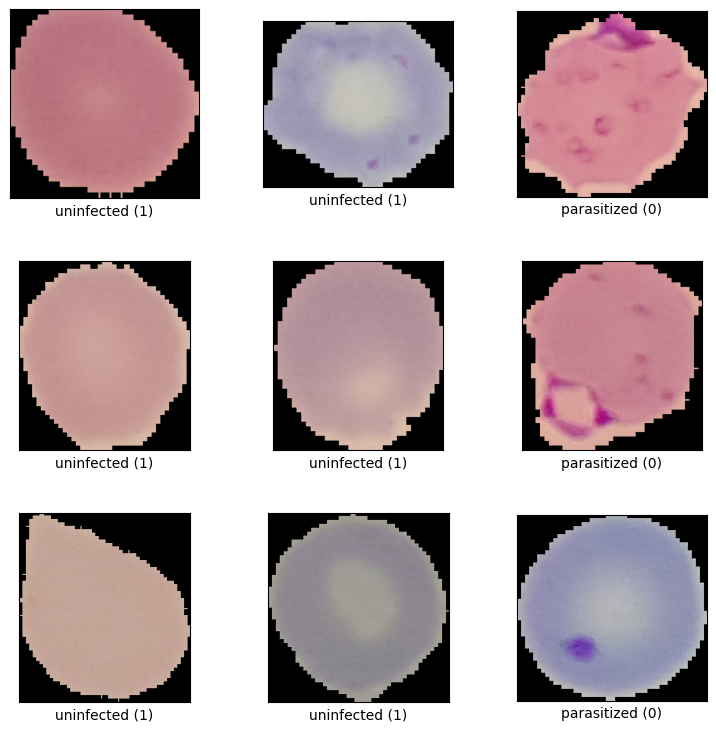

In [6]:
tfds.show_examples(ds, info, rows=3, cols=3);

From the above samples we can conclude that
- images are color encoded
- base colors differ
- the images seems to be carefully cropped
- the images are pure and free from artifacts such as qr-codes, watermarks or other annotations
- the images varies in size
- not all images are quadratic

### Statistical analysis

#### The dataset is balanced

The labels are 0 or 1, corresponding to _parazitized_ and _unifected_.

In [7]:
info.features['label'].names

['parasitized', 'uninfected']

Furthermore, the distribution of the images over the label is well balanced.

2024-10-24 16:02:24.003038: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<Axes: title={'center': 'Image count per label'}, xlabel='label', ylabel='image count'>

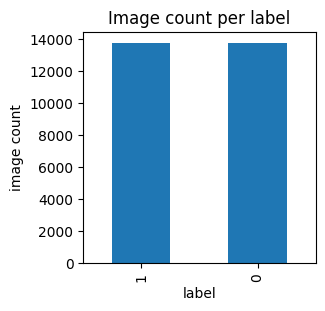

In [8]:
(DataFrame({
    'label': [d['label'].numpy() for d in ds]
    })['label']
    .value_counts()
    .plot.bar(title='Image count per label', figsize=(3,3), ylabel='image count', xlabel='label'))

#### Investigation of image dimensions

The images are reperesented by [tensorflow tensors](https://www.tensorflow.org/api_docs/python/tf/Tensor).

In [9]:
for image in ds.take(1):
  print(image['image'])

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(103, 103, 3), dtype=uint8)


Extract width, height, aspect ratio and size for each image and print a basic statistical analysis.

In [10]:
def get_image_characteristics(ds: tf.data.Dataset, sample_size: int) -> DataFrame:
  labels = [d['label'].numpy() for d in ds.take(sample_size)]
  image_size_width_height = [(
    len(d['image'].numpy().flatten()),
    d['image'].shape[0],
    d['image'].shape[1],
  ) for d in ds.take(sample_size)]

  return DataFrame({
    'label': labels,
    'size': [t[0] for t in image_size_width_height],
    'width': [t[1] for t in image_size_width_height],
    'height': [t[2] for t in image_size_width_height],
    'aspect ratio': [t[1]/t[2] for t in image_size_width_height],
  })
get_image_characteristics(ds,-1).describe()

2024-10-24 16:02:25.300174: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,label,size,width,height,aspect ratio
count,27558.000000,27558.000000,27558.000000,27558.000000,27558.000000
mean,0.500000,53507.269105,132.983453,132.487154,1.013867
std,0.500009,14902.714162,20.619650,20.015949,0.150037
min,0.000000,6600.000000,40.000000,46.000000,0.385366
25%,0.000000,44202.000000,121.000000,121.000000,0.925000
50%,0.500000,51870.000000,130.000000,130.000000,1.000000
75%,1.000000,60465.000000,145.000000,142.000000,1.086331
max,1.000000,371280.000000,385.000000,394.000000,2.184211


We can conclude that
- there is a big span in size
- there is also some variation in dimensions and geometry

To avoid overtraining due to external image characteristics, its wise to normalize with regards to size. This is probably best achieved by scaling images to a sensible size such as (121,121) which is smaller than (roughly) 75% of all images.

array([<Axes: >], dtype=object)

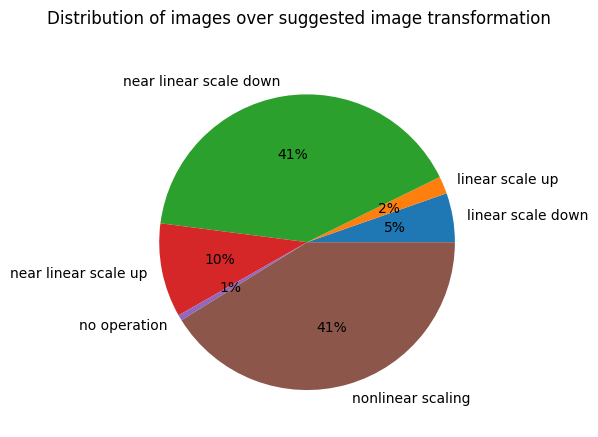

In [11]:
def get_image_characteristics_with_suggested_transform(ds: tf.data.Dataset, sample_size: int, d: int) -> DataFrame:
    def get_operation(actualw: int, actualh: int):
        if actualw/actualh == 1.0:
            return 'no operation' if actualw == d else 'linear scale up' if actualh < d else 'linear scale down'
        if abs(actualw/actualh - 1.0) < 0.1:
            return 'near linear scale up' if actualh < d else 'near linear scale down'
        return 'nonlinear scaling'

    df = get_image_characteristics(ds, sample_size)
    df['image transform'] = df.apply(lambda row: get_operation(row['width'], row['height']), axis=1)
    return df

(get_image_characteristics_with_suggested_transform(ds,-1, 121)
    .groupby('image transform')['image transform'].count()
    .plot.pie(x='image transform', subplots=True, autopct='%.0f%%', title='Distribution of images over suggested image transformation', xlabel='', ylabel=''))


- no operation covers images that already has the dimension (121,121)
- linear scale up/down covers square images
- near linear scale up/down covers images whith aspect ratio between 0.9 and 1.1 (i.e. almost square)
- nonlinear scaling covers standing or lying rectangles that doesnt fit our criteria of (near) squareness